In [14]:
import networkx as nx
import matplotlib.pyplot as plt

In [15]:
#All from other notebook
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram, plot_bloch_multivector

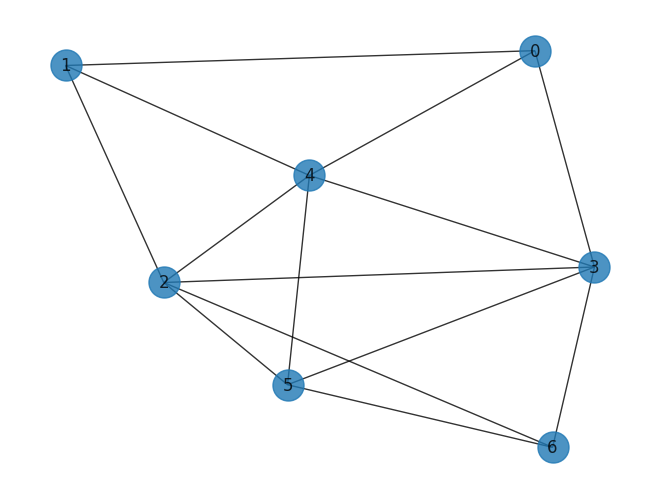

In [16]:
import networkx as nx
shotnum = 20000
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6])
G.add_edges_from([(0, 3), (0,1), (0,4), (1,4), (1,2), (4,2), (4,3), (4,5), (3,2),(3,6),(3,5),(2,5),(2,6),(6,5)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

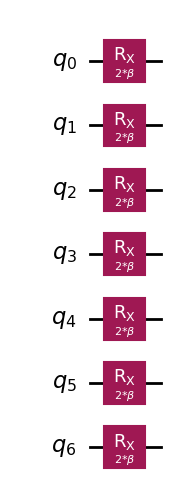

In [17]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = len(G.nodes)

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw('mpl')

(0, 3)
(0, 1)
(0, 4)
(1, 4)
(1, 2)
(2, 4)
(2, 3)
(2, 5)
(2, 6)
(3, 4)
(3, 6)
(3, 5)
(4, 5)
(5, 6)


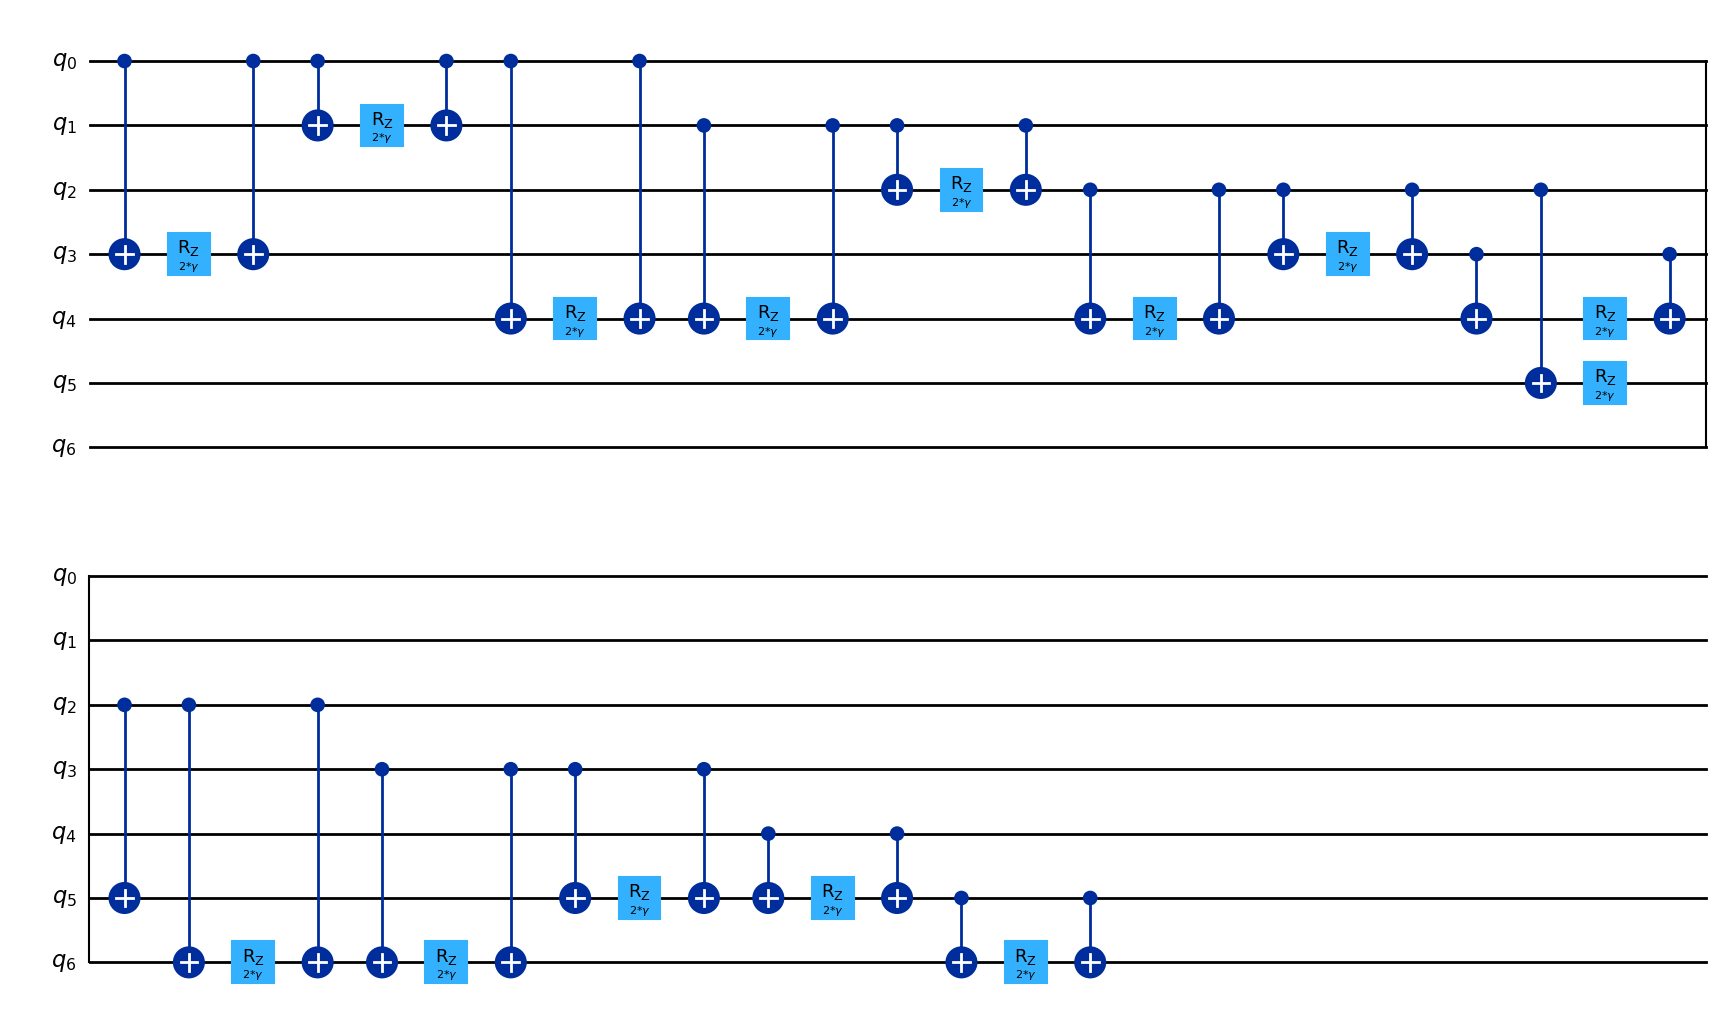

In [18]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    print(pair)
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    
qc_p.decompose().draw('mpl')


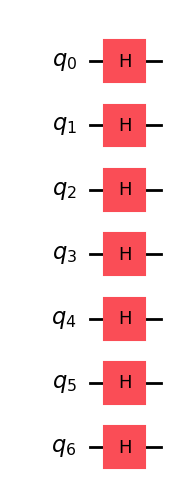

In [19]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw('mpl')

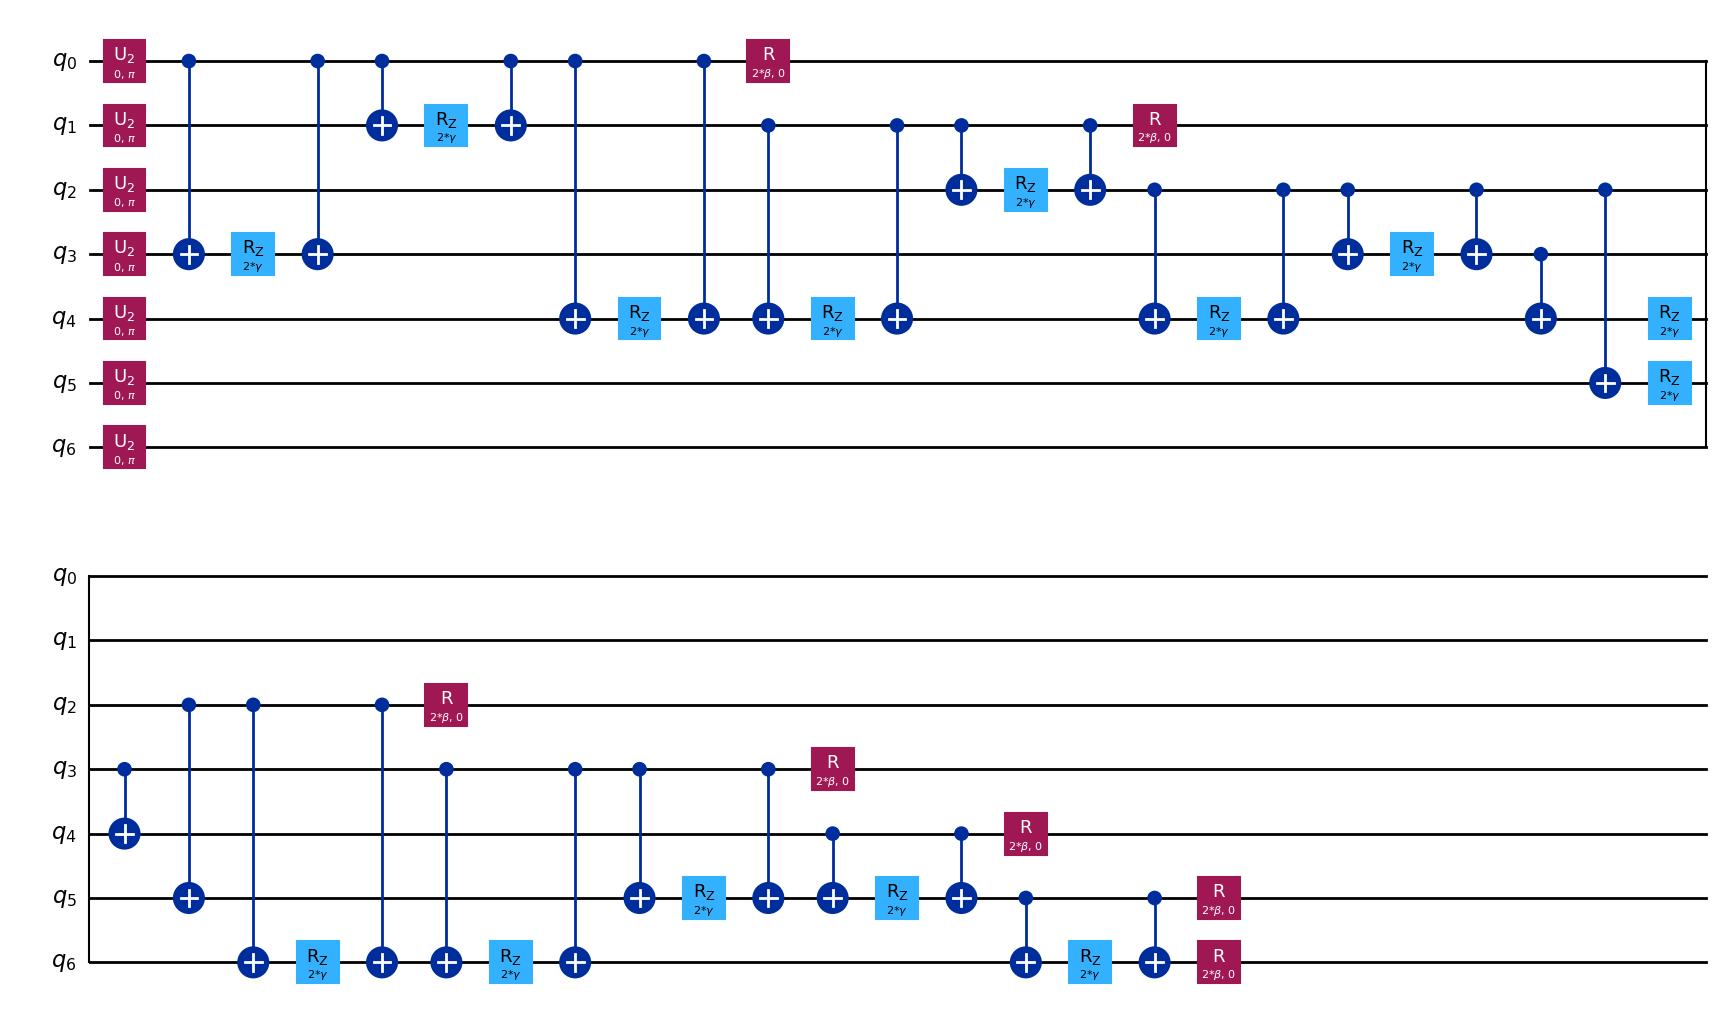

In [20]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw('mpl')

In [24]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
    return obj


def compute_expectation(counts, G):
    """
    Computes expectation value based on measurement results
    """
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
    print("returned: ", (avg/sum_count))
    return avg/sum_count

Bet = []
Gam = []
# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    """
    Creates a parametrized qaoa circuit
    """
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    beta = theta[:p]
    gamma = theta[p:]
    #extra start
    print('beta: ', beta)
    print('gamma: ', gamma)
    Bet.append(beta)
    Gam.append(gamma)
    #gamma, beta = PIDControl(gamma, beta, Gam, Bet)
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    for irep in range(0, p):
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])
        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
    qc.measure_all()
    return qc

def execute_circ(theta):
        qc = create_qaoa_circ(G, theta)
        counts = AerSimulator().run(qc, seed_simulator=10, shots=shotnum).result().get_counts()
        return compute_expectation(counts, G)

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, shots=shotnum):
    return execute_circ

<function execute_circ at 0x00000158889C3CE0>
beta:  [1.]
gamma:  [1.]
returned:  -7.2848
beta:  [1.]
gamma:  [1.]
returned:  -7.2848
beta:  [2.]
gamma:  [1.]
returned:  -6.5917
beta:  [-0.618034]
gamma:  [1.]
returned:  -7.2285
beta:  [0.38196603]
gamma:  [1.]
returned:  -6.58785
beta:  [1.381966]
gamma:  [1.]
returned:  -7.2653
beta:  [1.16932782]
gamma:  [1.]
returned:  -7.37985
beta:  [1.18211973]
gamma:  [1.]
returned:  -7.38485
beta:  [1.25845421]
gamma:  [1.]
returned:  -7.3692
beta:  [1.20495482]
gamma:  [1.]
returned:  -7.38185
beta:  [1.18905612]
gamma:  [1.]
returned:  -7.38535
beta:  [1.18716556]
gamma:  [1.]
returned:  -7.3846
beta:  [1.19512888]
gamma:  [1.]
returned:  -7.3841
beta:  [1.19137571]
gamma:  [1.]
returned:  -7.38535
beta:  [1.19137571]
gamma:  [1.]
returned:  -7.38535
beta:  [1.19137571]
gamma:  [2.]
returned:  -5.76625
beta:  [1.19137571]
gamma:  [-0.618034]
returned:  -6.43555
beta:  [1.19137571]
gamma:  [0.38196603]
returned:  -7.92005
beta:  [1.19137571]


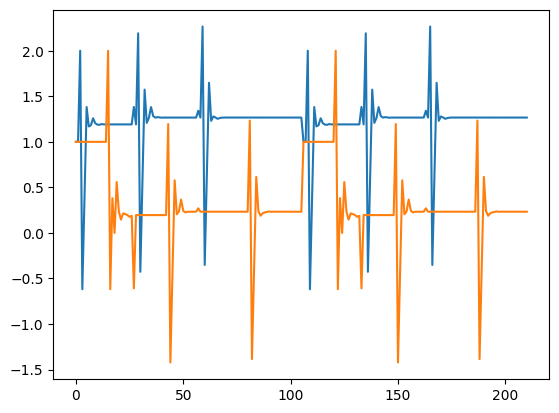

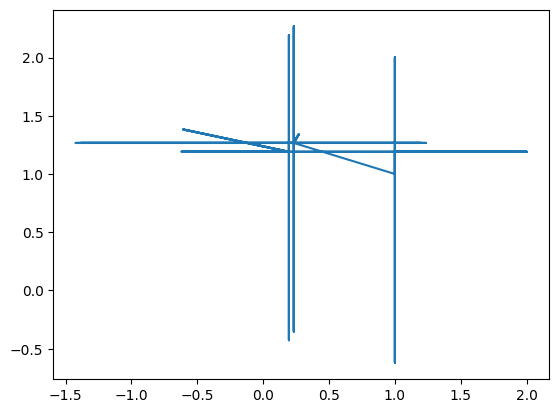

In [27]:
from scipy.optimize import minimize


expectation = get_expectation(G)
print(expectation)
res = minimize(expectation, [1.0, 1.0], method='Powell')          
res        

Tim = range(len(Bet))
plt.plot(Tim, Bet)
plt.plot(Tim, Gam)
plt.show()
plt.plot(Gam, Bet)
plt.show()

beta:  [1.26647135]
gamma:  [0.23278934]
{'1110110': 1, '1001100': 104, '0001110': 455, '0100101': 719, '1111010': 82, '0101011': 416, '0110101': 336, '1001101': 233, '1110001': 458, '1100101': 332, '0001010': 65, '0100001': 14, '0111111': 35, '1110010': 470, '0011001': 123, '1010101': 707, '1011001': 261, '0010101': 357, '0000100': 14, '0101101': 322, '0110011': 124, '1110101': 63, '0111010': 352, '0100110': 271, '0101111': 79, '0110001': 219, '1000101': 327, '0110100': 252, '0101100': 216, '1100011': 542, '0000001': 49, '0110110': 124, '0101010': 716, '1111011': 22, '1000111': 314, '0111101': 19, '0100011': 125, '1001110': 235, '1110000': 222, '1110111': 17, '1001011': 290, '0001101': 485, '0011110': 138, '0011000': 139, '1010100': 388, '1110100': 63, '1001010': 365, '0100111': 354, '1100010': 132, '0110000': 52, '1000001': 11, '1111101': 53, '0000111': 57, '0010100': 154, '1101010': 349, '1011000': 397, '1100110': 122, '0011100': 568, '0101110': 309, '0110010': 233, '1101000': 34, '

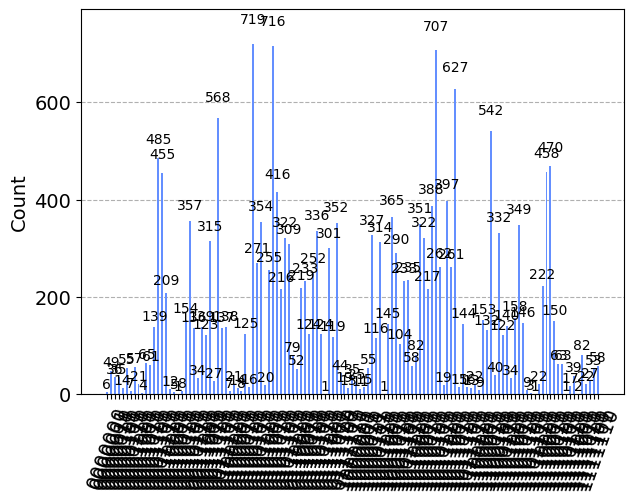

In [28]:
from qiskit.visualization import plot_histogram


qc_res = create_qaoa_circ(G, res.x)

counts = AerSimulator().run(qc_res, seed_simulator=10, shots=shotnum).result().get_counts()
print(counts)
plot_histogram(counts)
